# Introduction
<hr style = "border:2px solid black" ></hr>

<div class="alert alert-warning">
<font color=black>

**What?** PyMc - official introduction

</font>
</div>

# Under the hood
<hr style = "border:2px solid black" ></hr>

<div class="alert alert-info">
<font color=black>

- Probabilistic Programming allows for automatic Bayesian inference. 
- Gradient-based algorithms for Markov chain Monte Carlo (MCMC) sampling, known as Hamiltonian Monte Carlo (HMC). HMC and NUTS take advantage of gradient information from the likelihood to achieve much faster convergence than traditional sampling methods, especially for larger models. NUTS also has several self-tuning strategies for adaptively setting the tunable parameters of Hamiltonian Monte Carlo, which means you usually don't need to have specialized knowledge about how the algorithms work. 
- PyMC uses Aesara to compute gradients via automatic differentiation as well as compile probabilistic programs on-the-fly to one of a suite of computational backends for increased speed. 
- Aesara (a fork of the Theano project) is a library that allows expressions to be defined using generalized vector data structures called *tensors*, which are tightly integrated with the popular NumPy {class}`~numpy.ndarray` data structure, and similarly allow for broadcasting and advanced indexing, just as NumPy arrays do. Aesara also automatically optimizes the likelihood's computational graph for speed and allows for compilation to a suite of computational backends, including Jax and Numba.
- PyMC supports also non-gradient based sampling algorithms like Metropolis-Hastings and Slice sampling. These are used when we deal with discrete variables and thus have no meaningful gradient. We cannot use NUTS for sampling switchpoint or the missing disaster observations. Instead, we can use the Metropolis-Hastings because it is designed to handle discrete values.

    
</font>
</div>

# Imports
<hr style = "border:2px solid black" ></hr>

In [58]:
import arviz as az
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm

In [59]:
%config InlineBackend.figure_format = 'retina'
# Initialize random number generator
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")

# A Motivating Example: Linear Regression
<hr style = "border:2px solid black" ></hr>

<div class="alert alert-info">
<font color=black>


To introduce model definition, fitting, and posterior analysis, we first consider a simple Bayesian linear regression model with normal priors for the parameters. We are interested in predicting outcomes $Y$ as normally-distributed observations with an expected value $\mu$ that is a linear function of two predictor variables, $X_1$ and $X_2$.

$$\begin{aligned} 
Y  &\sim \mathcal{N}(\mu, \sigma^2) \\
\mu &= \alpha + \beta_1 X_1 + \beta_2 X_2
\end{aligned}$$

where $\alpha$ is the intercept, and $\beta_i$ is the coefficient for covariate $X_i$, while $\sigma$ represents the observation error. Since we are constructing a Bayesian model, we must assign a prior distribution to the unknown variables in the model. We choose zero-mean normal priors with variance of 100 for both regression coefficients, which corresponds to *weak* information regarding the true parameter values. We choose a half-normal distribution (normal distribution bounded at zero) as the prior for $\sigma$.

$$\begin{aligned} 
\alpha &\sim \mathcal{N}(0, 100) \\
\beta_i &\sim \mathcal{N}(0, 100) \\
\sigma &\sim \lvert\mathcal{N}(0, 1){\rvert}
\end{aligned}$$

</font>
</div>


## Generate data

In [60]:
# True parameter values
alpha, sigma = 1, 1
beta = [1, 2.5]

# Size of dataset
size = 100

# Predictor variable
X1 = np.random.randn(size)
X2 = np.random.randn(size) * 0.2

# Simulate outcome variable
Y = alpha + beta[0] * X1 + beta[1] * X2 + rng.normal(size=size) * sigma

Here is what the simulated data look like. We use the `pylab` module from the plotting library matplotlib. 

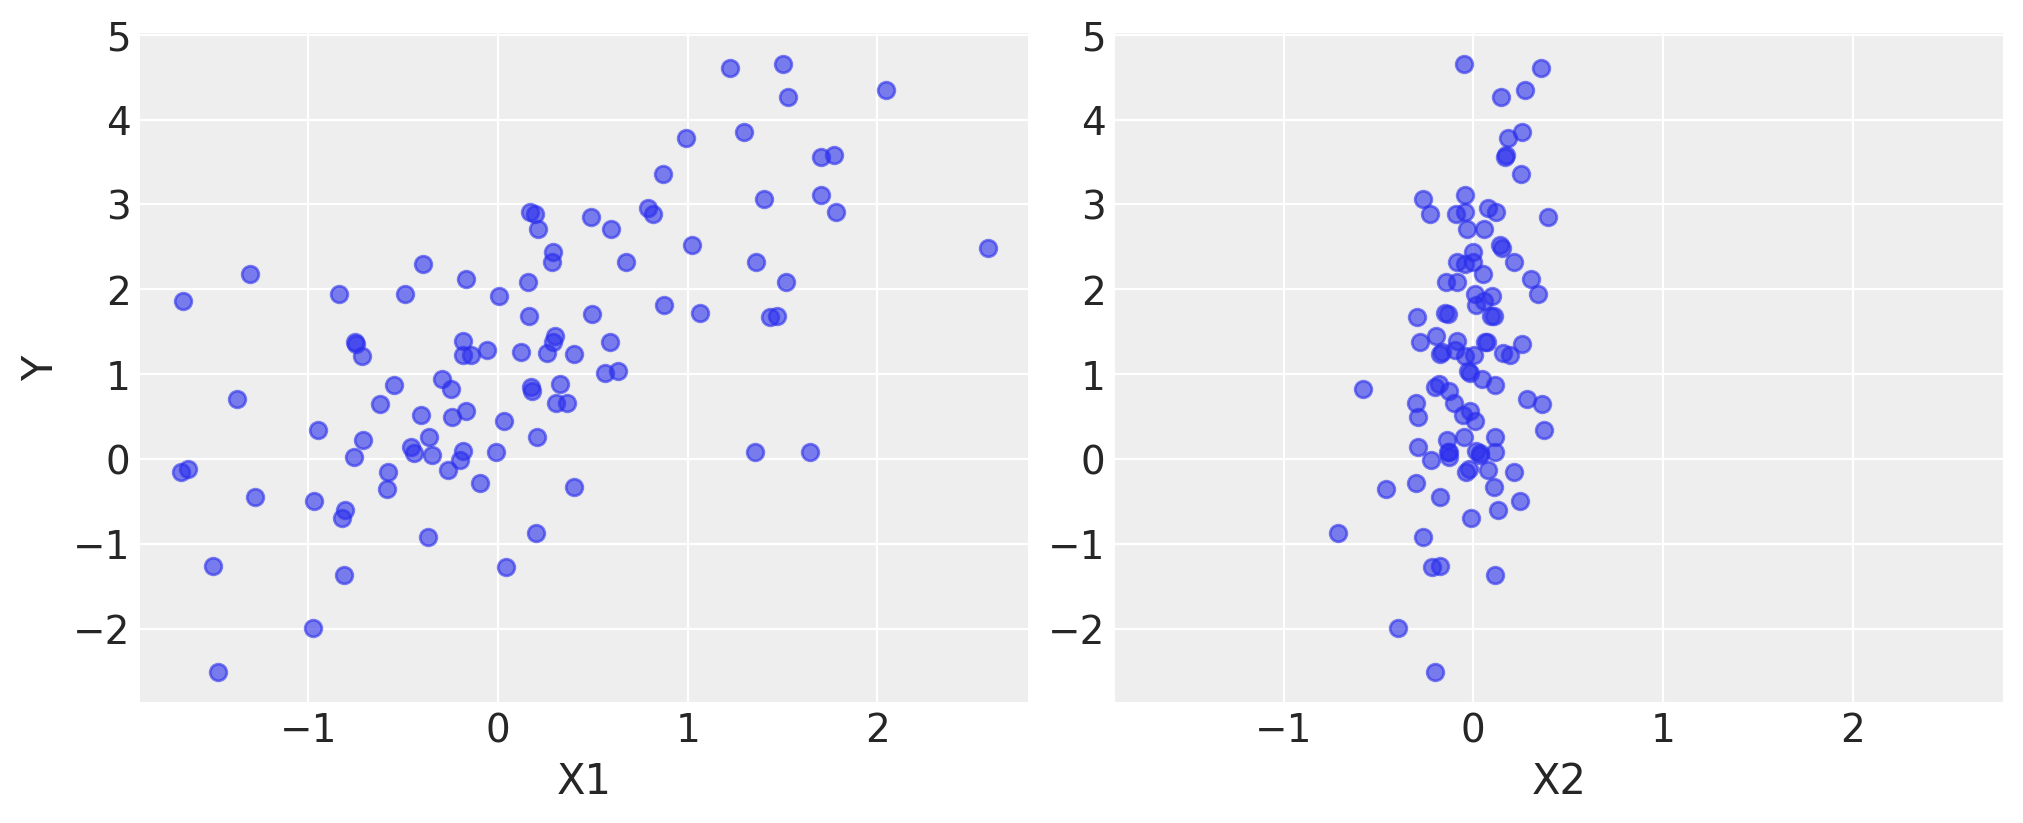

In [61]:
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(10, 4))
axes[0].scatter(X1, Y, alpha=0.6)
axes[1].scatter(X2, Y, alpha=0.6)
axes[0].set_ylabel("Y")
axes[0].set_xlabel("X1")
axes[1].set_xlabel("X2");

## Model Specification

<div class="alert alert-info">
<font color=black>

- Specifying this model in PyMC is straightforward because the syntax is as close to the statistical notation. 
- The final line of the model, defines `Y_obs`, the sampling distribution of the outcomes in the dataset. This is a special case of a stochastic variable that we call an **observed stochastic**, and represents the data likelihood of the model. It is identical to a standard stochastic, except that its `observed` argument, which passes the data to the variable, indicates that the values for this variable were observed, and should not be changed by any fitting algorithm applied to the model. Notice that, unlike for the priors of the model, the parameters for the normal distribution of `Y_obs` are not fixed values, but rather are the deterministic object `mu` and the stochastic `sigma`. This creates parent-child relationships between the likelihood and these two variables.
    
</font>
</div>

In [6]:
basic_model = pm.Model()

# Crreate a contect manage via with
with basic_model:

    # Priors for unknown model parameters
    alpha = pm.Normal("alpha", mu=0, sigma=10)
    beta = pm.Normal("beta", mu=0, sigma=10, shape=2)
    sigma = pm.HalfNormal("sigma", sigma=1)

    # Expected value of outcome
    mu = alpha + beta[0] * X1 + beta[1] * X2

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal("Y_obs", mu=mu, sigma=sigma, observed=Y)

In [7]:
with basic_model:
    # draw 1000 posterior samples
    idata = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 20 seconds.


In [8]:
idata

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

The various attributes of the `InferenceData` object can be queried in a similar way to a `dict` containing a map from variable names to `numpy.array`s. For example, we can retrieve the sampling trace from the `alpha` latent variable by using the variable name as an index to the `idata.posterior` attribute. The first dimension of the returned array is the chain index, the second dimension is the sampling index, while the later dimensions match the shape of the variable. We can see the first 5 values for the `alpha` variable in each chain as follows:

In [9]:
idata.posterior["alpha"].sel(draw=slice(0, 4))

<xarray.DataArray 'alpha' (chain: 4, draw: 5)>
array([[1.0135792 , 1.16247515, 1.28288373, 1.0336543 , 1.08975001],
       [1.23491412, 1.15173006, 1.31577369, 1.01515779, 1.10326413],
       [1.05210187, 1.04087184, 1.24816471, 1.07834006, 1.04824536],
       [1.02189606, 1.27914016, 1.15966992, 1.07359573, 1.27724988]])
Coordinates:
  * chain    (chain) int64 0 1 2 3
  * draw     (draw) int64 0 1 2 3 4

## Changing the sampling algorithm

<div class="alert alert-info">
<font color=black>

- If we wanted to use the slice sampling algorithm to `sigma` instead of NUTS (which was assigned automatically), we could have specified this as the `step` argument for `sample`.

</font>
</div>

In [10]:
with basic_model:
    # instantiate sampler
    step = pm.Slice()

    # draw 5000 posterior samples
    slice_idata = pm.sample(5000, step=step)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Slice: [alpha]
>Slice: [beta]
>Slice: [sigma]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 21 seconds.


## Posterior analysis

<div class="alert alert-info">
<font color=black>

- The left column consists of a smoothed histogram (using kernel density estimation) of the marginal posteriors of each stochastic random variable while the right column contains the samples of the Markov chain plotted in sequential order. 
- The `beta` variable, being vector-valued, produces two density plots and two trace plots, corresponding to both predictor coefficients.

</font>
</div>

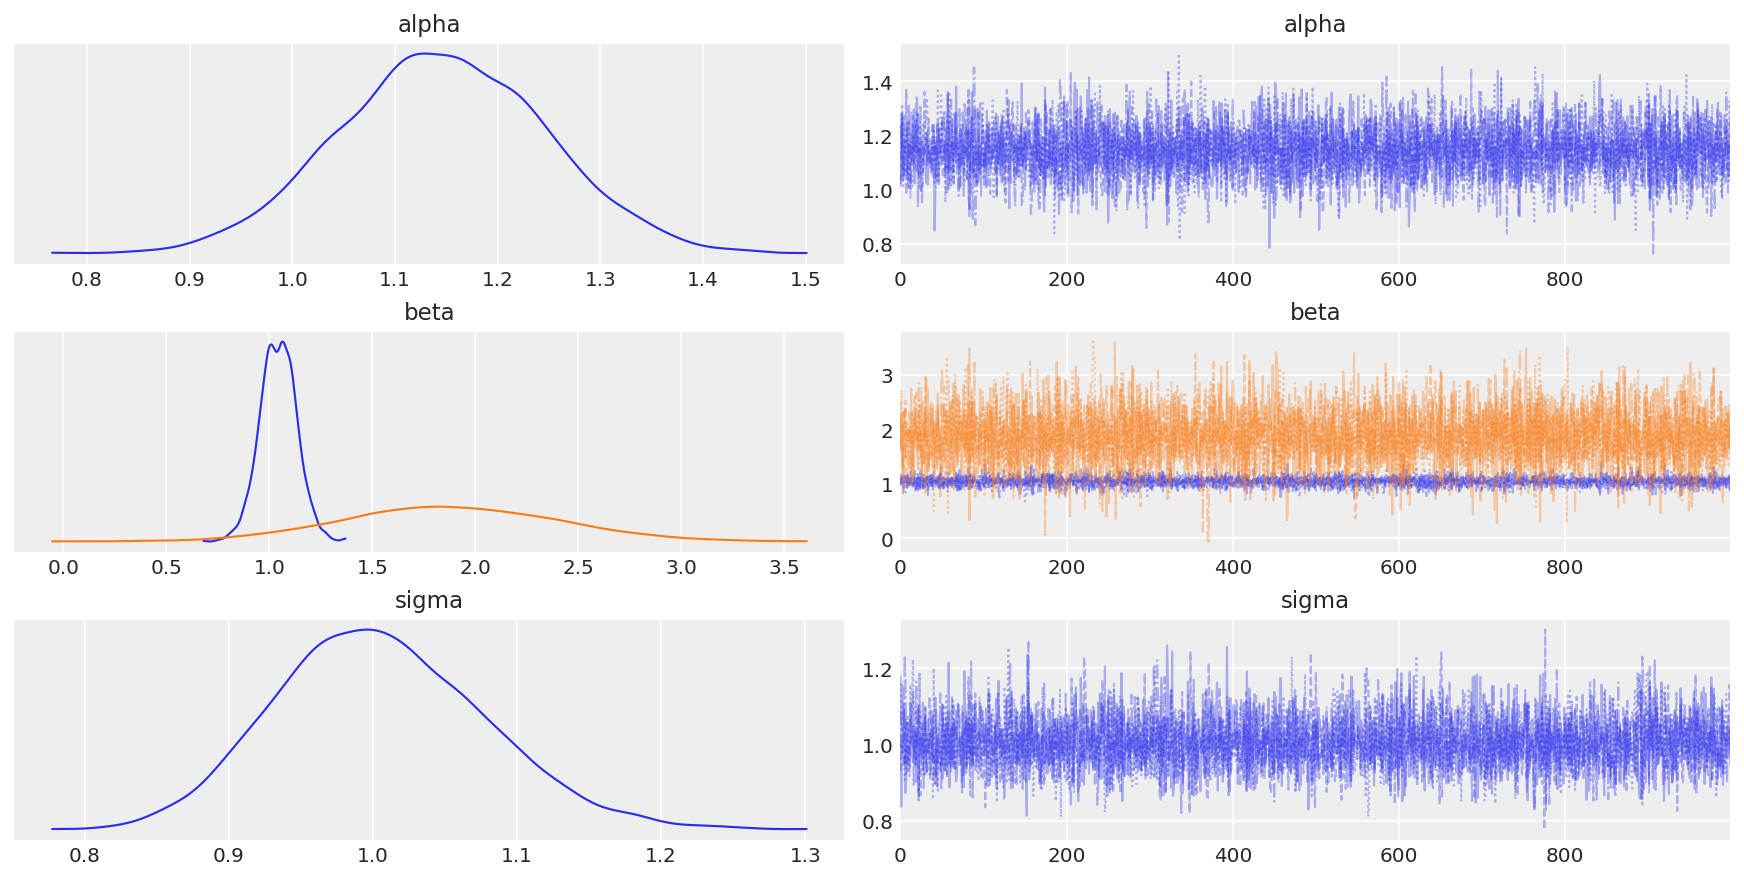

In [11]:
az.plot_trace(idata, combined=True);

In [12]:
# Common posterior statistics
az.summary(idata, round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,1.15,0.10,0.96,1.34,0.00,0.0,6001.47,3457.48,1.0
beta[0],1.04,0.09,0.87,1.21,0.00,0.0,5605.10,3144.50,1.0
beta[1],1.88,0.52,0.90,2.85,0.01,0.0,5940.99,3223.61,1.0
sigma,1.01,0.07,0.88,1.14,0.00,0.0,5526.36,2990.34,1.0


# References
<hr style = "border:2px solid black" ></hr>

<div class="alert alert-warning">
<font color=black>

- [This notebook code](https://www.pymc.io/projects/docs/en/stable/learn/core_notebooks/pymc_overview.html#pymc-overview)

</font>
</div>

# Requirements
<hr style = "border:2px solid black" ></hr>

In [57]:
%load_ext watermark
%watermark -v -iv

Python implementation: CPython
Python version       : 3.10.4
IPython version      : 8.3.0

pandas    : 1.4.4
matplotlib: 3.5.3
aesara    : 2.8.2
json      : 2.0.9
autopep8  : 1.7.0
arviz     : 0.12.1
pymc      : 4.1.7
numpy     : 1.21.6

